<a href="https://colab.research.google.com/github/PomazkinG/Particle/blob/master/DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.image import rot90
import pandas as pd
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from matplotlib import pyplot as plt

In [31]:
def batch_rotate(images, indices):
    images_with_channel = images[:, :, :, numpy.newaxis]
    images_with_channel[indices] = rot90(images_with_channel[indices])
    return images_with_channel / 255.

def prepare_mnist():
    rng = numpy.random.RandomState(0)
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    rotate_train = rng.choice(2, size=x_train.shape[0]).astype(numpy.bool)
    rotate_test = rng.choice(2, size=x_test.shape[0]).astype(numpy.bool)
    x_train = batch_rotate(x_train, rotate_train)
    x_test = batch_rotate(x_test, rotate_test)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    rotate_train = rotate_train.reshape((-1, 1))
    rotate_test = rotate_test.reshape((-1, 1))
    return x_train, x_test, y_train, y_test, rotate_train, rotate_test
  
x_train, x_test, y_train, y_test, y_rot_train, y_rot_test = prepare_mnist()
y_rot_train = y_rot_train*1
y_rot_test = y_rot_test*1
print(x_train.shape, y_train.shape, y_rot_train.shape)

(60000, 28, 28, 1) (60000, 10) (60000, 1)


In [0]:
input_shape = [x_train.shape[1],x_train.shape[2],x_train.shape[3]]
batch_size = 128
num_epoch = 3
initial_lr = 1e-3
opt = keras.optimizers.Adam() #lr=initial_lr, decay=initial_lr / epochs)
losses = {"digit_output": "categorical_crossentropy", "rotation_output": "binary_crossentropy"}
lossWeights = {"digit_output": 1.0, "rotation_output": 1.0}

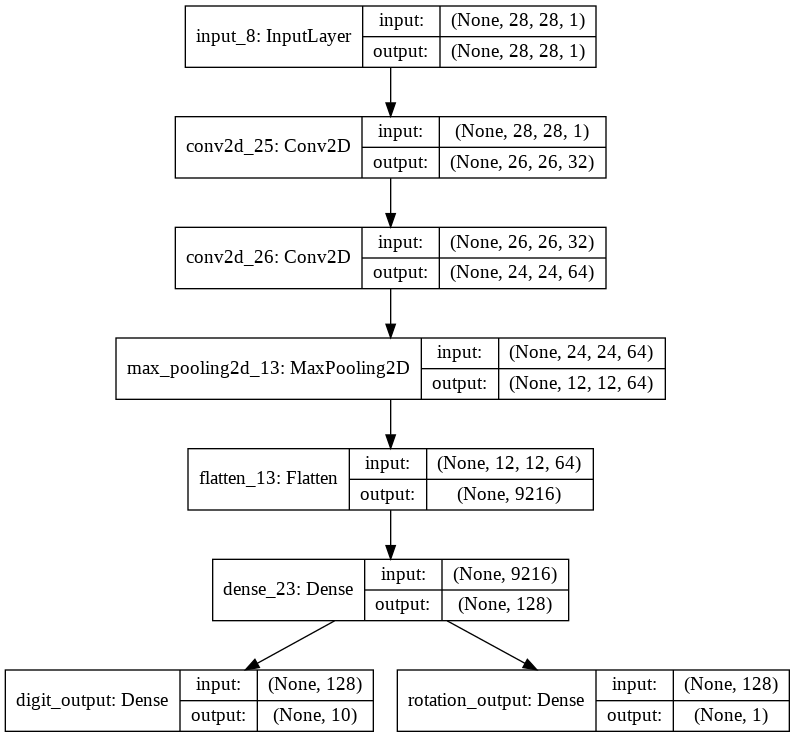

In [33]:
input_layer = Input(shape=input_shape)
Conv_1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(input_layer)
Conv_2 = Conv2D(64, (3, 3), activation='relu')(Conv_1)
Max_Pooling = MaxPooling2D(pool_size=(2, 2))(Conv_2)
Flat = Flatten()(Max_Pooling)
Dense_1 = Dense(128, activation='relu')(Flat)

#digit recognition
digit_output = Dense(y_train.shape[1], activation='softmax', name = 'digit_output')(Dense_1)

#rotation recognition
rotation_output = Dense(y_rot_train.shape[1], activation='sigmoid', name = 'rotation_output')(Dense_1)

model = Model(inputs=input_layer, outputs=[digit_output, rotation_output])
keras.utils.plot_model(model, 'my_first_model.png', show_shapes=True)

In [34]:
model.compile(loss=losses,
              optimizer=opt,
              loss_weights=lossWeights,
              metrics=['accuracy'])
model_log = model.fit(x_train,
	{"digit_output": y_train, "rotation_output": y_rot_train},
	validation_data=(x_test,
		{"digit_output": y_test, "rotation_output": y_rot_test}),
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 140s 2ms/step - loss: 0.2906 - digit_output_loss: 0.2506 - rotation_output_loss: 0.0399 - digit_output_accuracy: 0.9224 - rotation_output_accuracy: 0.9860 - val_loss: 0.1002 - val_digit_output_loss: 0.0866 - val_rotation_output_loss: 0.0126 - val_digit_output_accuracy: 0.9717 - val_rotation_output_accuracy: 0.9956
Epoch 2/3
60000/60000 [==============================] - 140s 2ms/step - loss: 0.0761 - digit_output_loss: 0.0658 - rotation_output_loss: 0.0102 - digit_output_accuracy: 0.9798 - rotation_output_accuracy: 0.9966 - val_loss: 0.0725 - val_digit_output_loss: 0.0605 - val_rotation_output_loss: 0.0112 - val_digit_output_accuracy: 0.9802 - val_rotation_output_accuracy: 0.9963
Epoch 3/3
60000/60000 [==============================] - 140s 2ms/step - loss: 0.0450 - digit_output_loss: 0.0386 - rotation_output_loss: 0.0064 - digit_output_accuracy: 0.9878 - rotation_output_accuracy:

In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0]) #Test loss: 0.0296396646054
print('Test accuracy:', score[1]) #Test accuracy: 0.9904

Test loss: 0.07858740667637083
Test accuracy: 0.9824000000953674


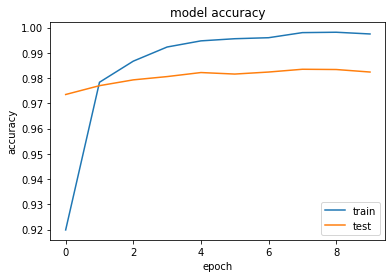

In [0]:
plt.plot(model_log.history['accuracy'])
plt.plot(model_log.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')